# Introduction
---
[Delmarva Power & Light](https://en.wikipedia.org/wiki/Delmarva_Power) (DPL) is an electricity and natural gas utility headquartered in Wilmington, Deleware.  Their service areas extend throughout much of Deleware and Maryland's Eastern Shore with over 500,000 electric customers.  This notebook examines a sample of their load profile data.

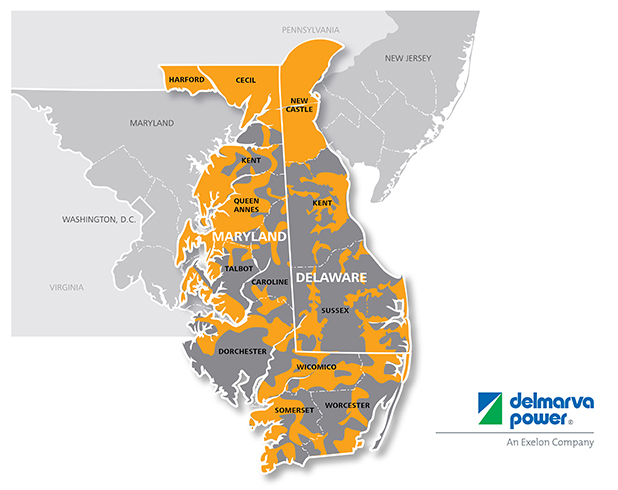

In [1]:
from IPython.display import Image
Image(url='https://www.delmarva.com/SiteCollectionImages/Service%20Area%20Map.jpg', embed=True)

Load profile data represents "average" hourly electricity usage in kilowatt-hours (KWh) for segments of customers.  These segments are typically based on the customer type (e.g. Residential, Commercial, Industrial) and magnitude of usage measured by either annual usage or maximum usage at a given time.  This data is often provided by utilities and is used by Load Serving Entities (LSEs) to develop hourly estimates of customer usage when only monthly metered usage data is available.

# Dependencies
---
- `delmarva_load_profiles.py` : A user-built module that acts as an API to download and parse load profile data.
- `delmarva_lp_code_mapping.csv` : A list of codes used by *delmarva_load_profiles* module in working environment.

# Notes
---
* All days have 24 observations.  The two Hour 2 observations on Fall Daylight Saving Time transition dates are summed, unless otherwise specified.
* *delmarva_load_profiles* module has not been tested extensively.

# References
---
* [Delmarva Home Page](https://www.delmarva.com)
* [Delmarva Class Load Profile Info](http://www.pepcoholdings.com/library/templates/interior.aspx?pageid=6442454556)

In [1]:
%matplotlib inline
from datetime import date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from delmarva_load_profiles import Delmarva
sns.set()

# Download Sample of Load Profile Data from Delmarva Website for Last Year
The data come in tabular format with hourly observations as columns and segment and date attributes as rows.

In [2]:
dpl = Delmarva()
end_date = date.today() - pd.Timedelta(2, 'D')
start_date = end_date - pd.Timedelta(364, 'D')
print('Downloading all available Delaware and Maryland data for {:%b %d, %Y} to {:%b %d, %Y}...\n'
      .format(start_date, end_date))
lp = dpl.get_lp_data(start_date, end_date)
print('\nDownload complete.\n')
lp.head()



Download complete.



segment       date    H01    H02    H03    H04    H05    H06    H07    H08  \
0   DEDGD 2017-02-08   7.09   6.75   6.66   6.56   6.65   7.10   7.79   8.47   
1   DEDGL 2017-02-08  52.63  51.31  48.84  50.11  53.42  57.30  64.33  69.24   
2   DEDGN 2017-02-08   0.79   0.77   0.76   0.76   0.76   0.75   0.81   0.76   
3   DEDGP 2017-02-08  30.60  30.23  29.76  29.49  29.80  31.05  34.12  34.70   
4   DEDGS 2017-02-08   3.24   3.10   3.06   3.02   3.05   3.22   3.50   3.74   

   ...      H15    H16    H17    H18    H19    H20    H21    H22    H23    H24  
0  ...    10.59  10.40  10.34   9.62   9.87   9.96   9.51   8.58   7.75   7.28  
1  ...    83.07  83.39  79.97  76.08  76.40  73.32  68.13  58.22  55.94  53.58  
2  ...     0.86   0.87   0.89   0.82   0.83   0.85   0.80   0.77   0.75   0.74  
3  ...    38.46  37.51  35.52  35.47  38.74  38.71  37.39  34.50  32.00  30.65  
4  ...     4.65   4.58   4.56   4.23   4.37   4.40   4.18   3.80   3.47   3.27  

[5 rows x 26 columns]

### Save a Copy of the Raw Data
**Warning:** This will erase all existing data if mode `"w"` is used.

In [3]:
lp.to_hdf('delmarva_data.h5', key='raw_{:%Y%m%d}'.format(date.today()), mode='w')

# Check Data Quality

### Check Data Types and Number of Observations

In [5]:
lp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5551 entries, 0 to 5550
Data columns (total 26 columns):
segment    5551 non-null object
date       5551 non-null datetime64[ns]
H01        5551 non-null float64
H02        5551 non-null float64
H03        5551 non-null float64
H04        5551 non-null float64
H05        5551 non-null float64
H06        5551 non-null float64
H07        5551 non-null float64
H08        5551 non-null float64
H09        5551 non-null float64
H10        5551 non-null float64
H11        5551 non-null float64
H12        5551 non-null float64
H13        5551 non-null float64
H14        5551 non-null float64
H15        5551 non-null float64
H16        5551 non-null float64
H17        5551 non-null float64
H18        5551 non-null float64
H19        5551 non-null float64
H20        5551 non-null float64
H21        5551 non-null float64
H22        5551 non-null float64
H23        5551 non-null float64
H24        5551 non-null float64
dtypes: datetime64[ns](1), fl

## Check for Duplicates
There should be unique observations by day and segment.

In [4]:
dups = lp.duplicated(subset=['segment', 'date'], keep=False)
print('{:.0f} duplicates'.format(dups.sum()/2))

75 duplicates


### Which days and segments are duplicated?

In [12]:
lp[dups].groupby(['date', 'segment']).size().unstack().rename(index=lambda dt: dt.strftime('%b %d, %Y'))

C:\Users\DG11983\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match

It's not clear why there are duplicates.  The observations may be duplicated on the source website or there may be a bug in the extraction code.  Regardless, we're just going to remove them so we can look at the data.

### Remove Dups

In [6]:
lp.drop_duplicates(subset=['segment', 'date'], inplace=True)
lp.shape

(5461, 26)

## Check for Missing Values
Dates ***should*** be continuous and observations should be available for ***all*** segments found in this sample.

### Fill in null records for missing observations

In [7]:
rng = pd.date_range(start_date, end_date)
segments = lp.segment.unique()
idx = pd.MultiIndex.from_product([segments, rng], names=['segment', 'date'])
lp = lp.set_index(['segment', 'date']).reindex(idx)
mask = lp.isnull().any(1)
print('{:.0f} missing observations'.format(mask.sum()))

14 missing observations


### Which days and segments are missing?

In [11]:
(lp[mask]
 .groupby(level=['date', 'segment']).size()
 .unstack()
 .reindex(columns=segments)
 .rename(index=lambda dt: dt.strftime('%b %d, %Y'))).style.highlight_null('#EC407A')

### (Linearly) Interpolate Missing Values by Profile
For each segment, linearly interpolate observations between missing days.  This provides a more accurate representation when aggregating the data. 

In [14]:
lp_interpolated = (lp
                   .groupby(level='segment')
                   .transform(lambda frame: frame.interpolate()))
lp_interpolated['interpolated'] = mask
lp_interpolated.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5475 entries, (DEDGD, 2017-02-08 00:00:00) to (MDDTN, 2018-02-07 00:00:00)
Data columns (total 25 columns):
H01             5475 non-null float64
H02             5475 non-null float64
H03             5475 non-null float64
H04             5475 non-null float64
H05             5475 non-null float64
H06             5475 non-null float64
H07             5475 non-null float64
H08             5475 non-null float64
H09             5475 non-null float64
H10             5475 non-null float64
H11             5475 non-null float64
H12             5475 non-null float64
H13             5475 non-null float64
H14             5475 non-null float64
H15             5475 non-null float64
H16             5475 non-null float64
H17             5475 non-null float64
H18             5475 non-null float64
H19             5475 non-null float64
H20             5475 non-null float64
H21             5475 non-null float64
H22             5475 non-null float64
H23   

#### Double check the number of interpolated values

In [15]:
lp_interpolated.interpolated.value_counts()

False    5461
True       14
Name: interpolated, dtype: int64

# Transform for Plotting
Now that we have a clean data set, let's parse out some attributes and reshape it for easier visualization.  Combined with information from Delarmarva's website, much information can be gleaned from the segments and the dates.

## Parsed Attributes
* **hour** : Hour of the day (1 - 24).  Represents the interval ending at that number, i.e. 1 is midnight to 1 AM, 2 is 1:01 AM to 2 AM, ..., 24 is 11:00 PM to midnight of the next day.
* **day** : Weekday name (Sunday, Monday, ..., Saturday).
* **date_label** : *Month day* formatted date.
* **state** : US state (MD or DE).
* **profile** : Two character code for specific load profile.
* **profile_name** : More descriptive name for profile from utility.
* **customer_type** : Type of customer (Residential, Commercial, Other).
* **season** : Season of the year, e.g. summer (defined as Jun 16 - Sep 15).

#### Segment Mappings

In [16]:
profiles = {'RS': 'Residential Service', 'RH': 'Residential Heating', 
            'GS': 'Small General Service', 'GL': 'Large General Service', 
            'GP': 'General Service, Primary', 'GT': 'General Service - Transmission', 
            'OL': 'Outdoor Lighting', 'TN': 'Telecommunication Network Service',
            'GD': 'General Service', 'GN': 'General Service - Other'}

customer_types = {'G': 'Commercial', 'R': 'Residential', 'O': 'Other',
                  'T': 'Other'}

#### Reshape with Hours by Row
[Tidy Data](http://vita.had.co.nz/papers/tidy-data.html) is the best format for our purposes here.

In [17]:
lp_tidy = (lp_interpolated
           .reset_index()
           .melt(['segment', 'date', 'interpolated'], 
                 var_name='hour', 
                 value_name='load'))

#### Add attributes

In [ ]:
def get_season(dt):
    """
    Get season of the year (winter, summer, spring, fall) for a given date.
    
    
    winter : December 16 - March 15
    spring : March 16 - June 15
    summer : June 16 - September 15
    fall.  : September 16 - December 15
    """
    d = pd.Timestamp(dt)
    yr = d.year
    dx = d.replace(year=yr-1, month=12, day=16)
    dy = d.replace(month=2, day=15)
    mo3 = pd.Timedelta(3, 'M')
    for i, season in enumerate(['winter', 'spring', 'summer', 'fall']):
        if dx <= d <= dy:
            return season
        else:
            dx += mo3
            dy += mo3
    else:
        return 'winter'

In [18]:
lp_tidy['season'] = lp_tidy.date.transform(get_season)
lp_tidy['hour'] = lp_tidy.hour.str.slice(start=1).astype('int')
lp_tidy['day'] = lp_tidy.date.dt.weekday_name
lp_tidy['date_label'] = lp_tidy.date.dt.strftime('%b %d')
lp_tidy['state'] = lp_tidy.segment.str.slice(stop=2)
lp_tidy['profile'] = lp_tidy.segment.str.slice(start=-2)
lp_tidy['profile_name'] = lp_tidy.profile.map(profiles)
lp_tidy['customer_type'] = lp_tidy.profile.transform(lambda x: customer_types[x[0]])

In [20]:
lp_tidy.head()

segment       date  interpolated  hour  load        day date_label state  \
0   DEDGD 2017-02-08         False     1  7.09  Wednesday     Feb 08    DE   
1   DEDGD 2017-02-09         False     1  8.09   Thursday     Feb 09    DE   
2   DEDGD 2017-02-10         False     1  9.43     Friday     Feb 10    DE   
3   DEDGD 2017-02-11         False     1  9.14   Saturday     Feb 11    DE   
4   DEDGD 2017-02-12         False     1  8.70     Sunday     Feb 12    DE   

  profile     profile_name customer_type  season  
0      GD  General Service    Commercial  winter  
1      GD  General Service    Commercial  winter  
2      GD  General Service    Commercial  winter  
3      GD  General Service    Commercial  winter  
4      GD  General Service    Commercial  winter

#### Save Copy of Tidy Data

In [38]:
lp_tidy.to_hdf('delmarva_data.h5', key='lp_tidy_{:%Y%m%d}'.format(date.today()))

### Take an inventory
Number of observations by state and profile.

In [37]:
def highlight_positives(s, bg_color='yellow', font_color='black'):
    """
    Highlight the positive values in a Series.
    """
    is_pos = s > 0
    return ['background-color: {bg_color}; color: {font_color}'
            .format(bg_color=bg_color, font_color=font_color) 
            if v else '' for v in is_pos]

def gray_zeros(s):
    """Gray out zero values to reduce emphasis."""
    is_zero = s == 0
    return ['color: #D6DBDF' if v else '' for v in is_zero]

(lp_tidy
 .groupby(['state', 'profile_name', 'customer_type']).size()
 .unstack([2, 1], fill_value=0)
 .sort_index(axis=1)
 .astype('int')
 .style
     .apply(highlight_positives, bg_color='#3498DB', font_color='white')
     .apply(gray_zeros))

# Plot

## What Does the Distribution of Load Look Like by Hour and Season?

In [34]:
def show_xlabels(facet_grid):
    """Show the x-axis labels for all plots in seaborn facet grid."""
    for ax in facet_grid.axes:
        plt.setp(ax.get_xticklabels(), visible=True)

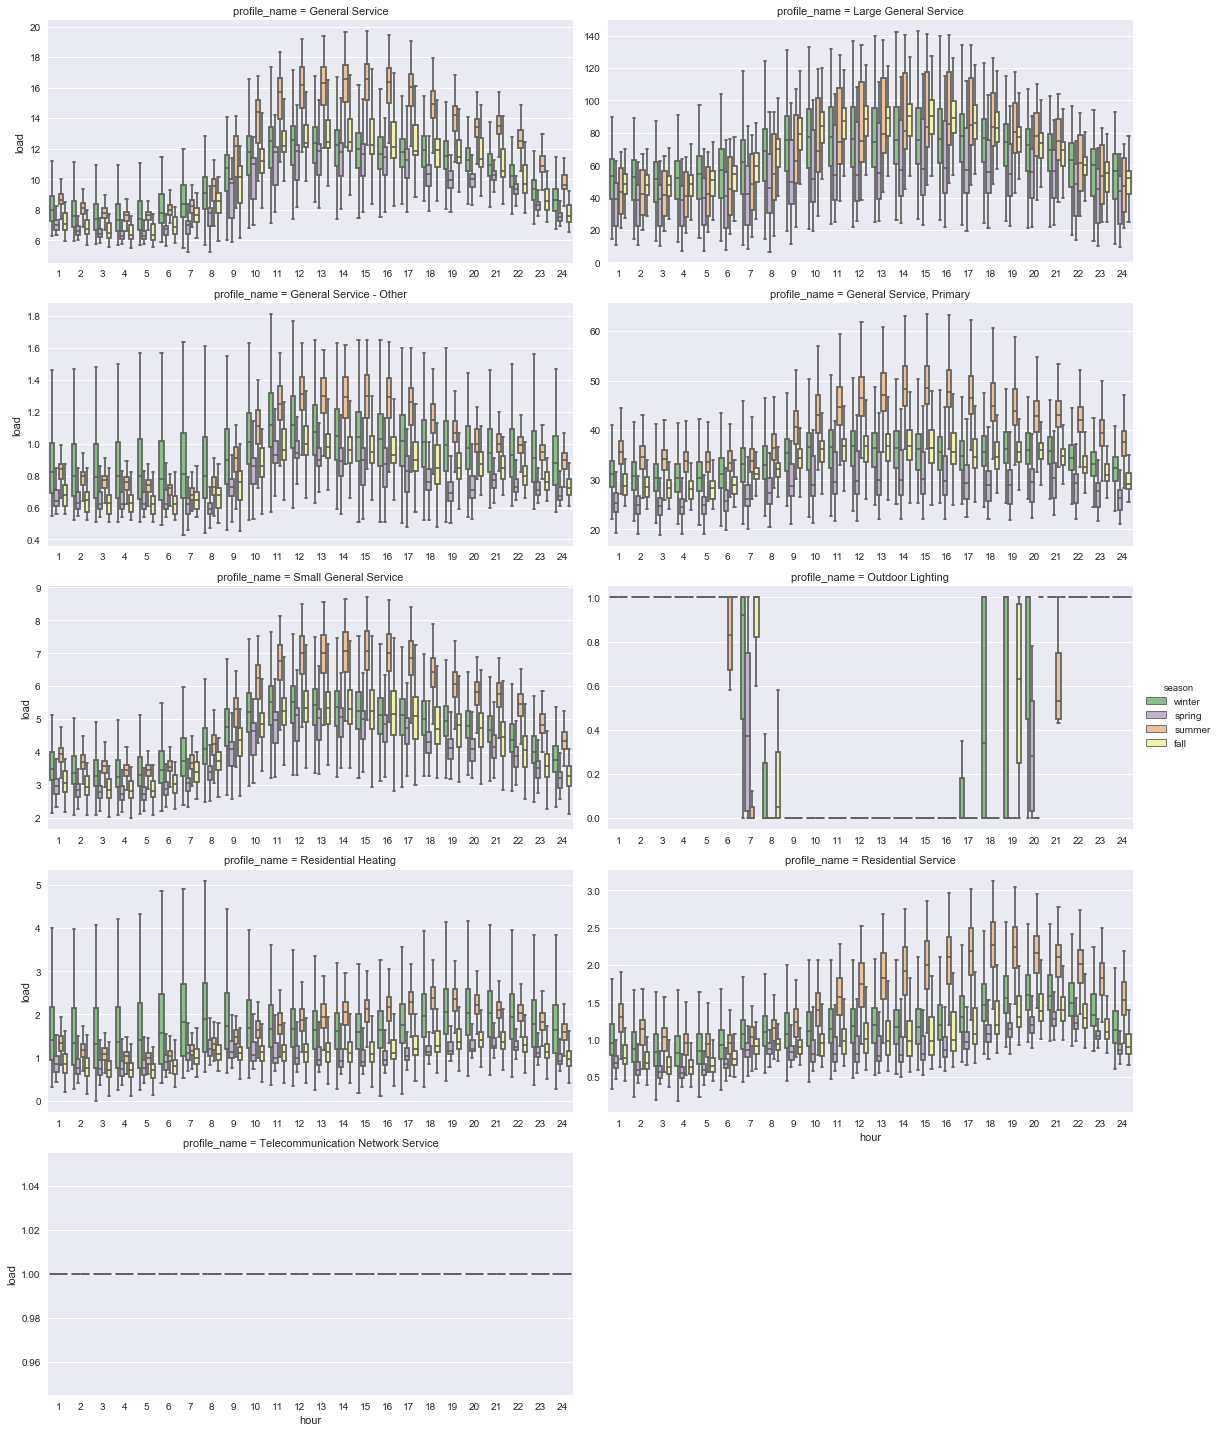

In [35]:
g = sns.factorplot(data=lp_tidy, x='hour', y='load', hue='season', kind='box',
                   col='profile_name', col_wrap=2, aspect=2, sharey=False,
                   palette='Accent', showfliers=False)
show_xlabels(g)

#### Some observations:
* Residential customers generally use the most electricity around 7 - 9 AM and 8 - 10 PM in the winter and spring.
* Spring and winter are typically in line in terms of magnitude and hourly profile, but summer usage is generally higher, especially after 10 AM.
* Residential Heating (RH) customers have less of a difference in their summer usage, but large variances in the winter usage.

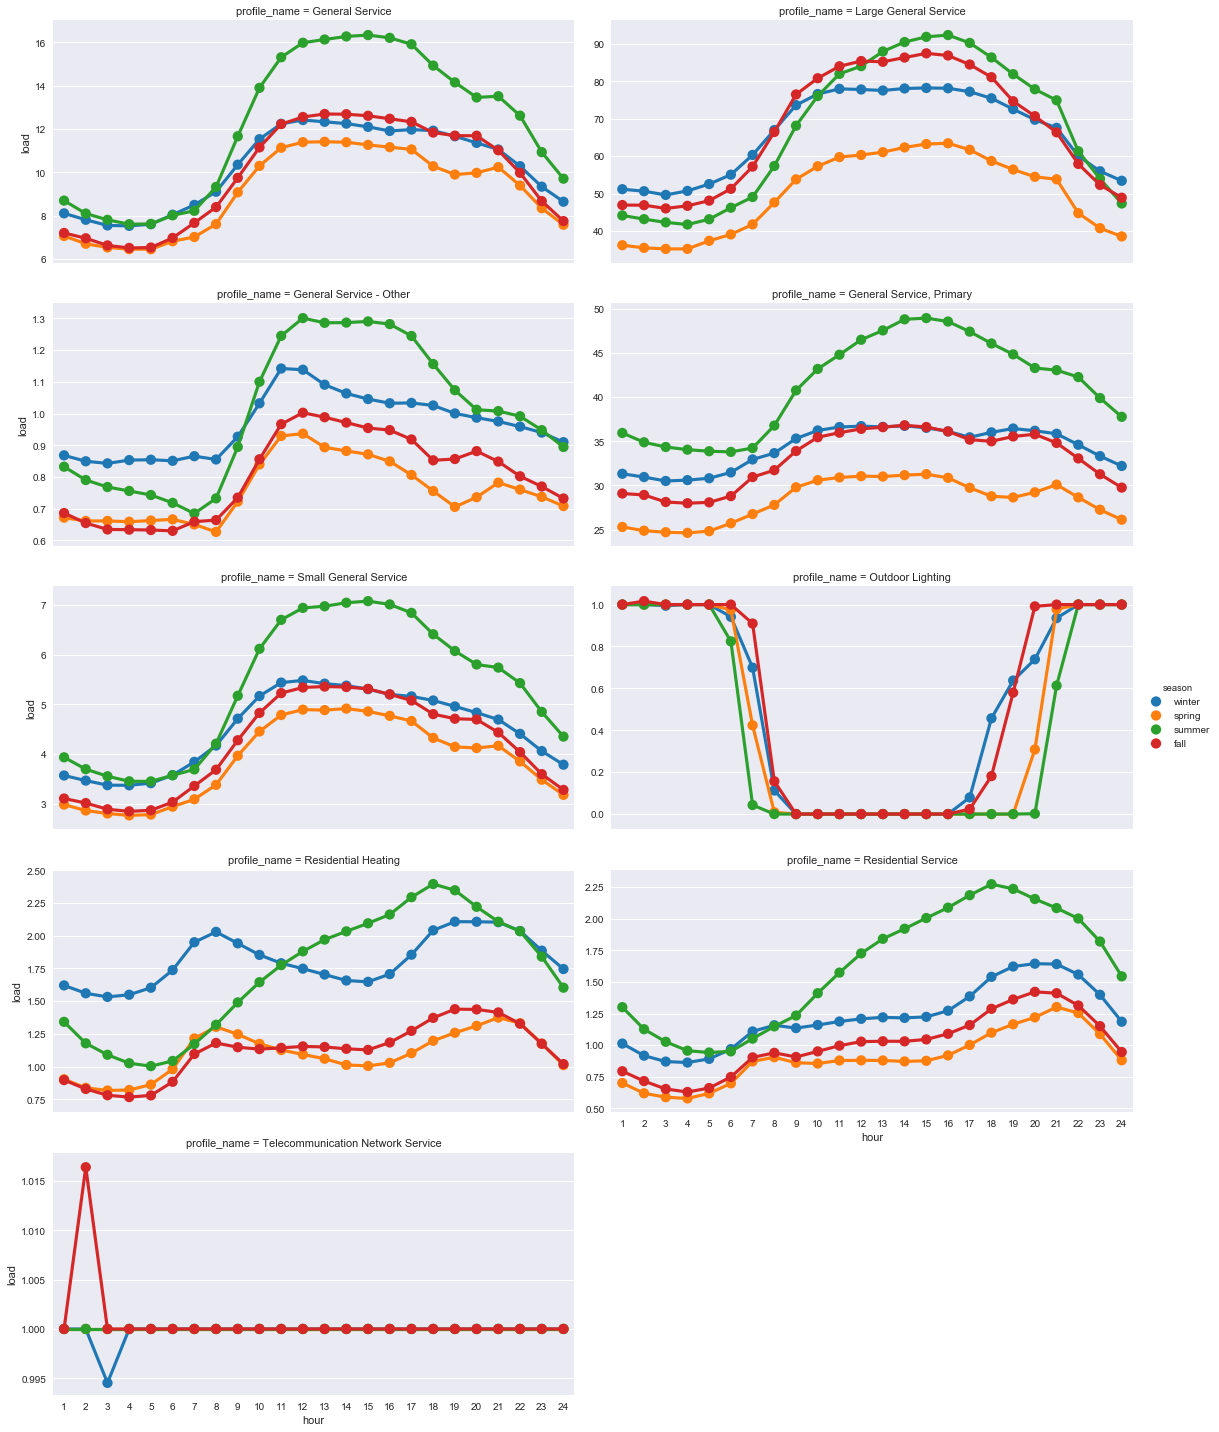

In [18]:
g = sns.factorplot(data=lp_tidy, x='hour', y='load', hue='season', kind='point',
                   col='profile_name', col_wrap=2, aspect=2, sharey=False,
                   palette='tab10', ci=None)

## How Have the Profiles Changed Over Time?
Aggregate load by week and segment.

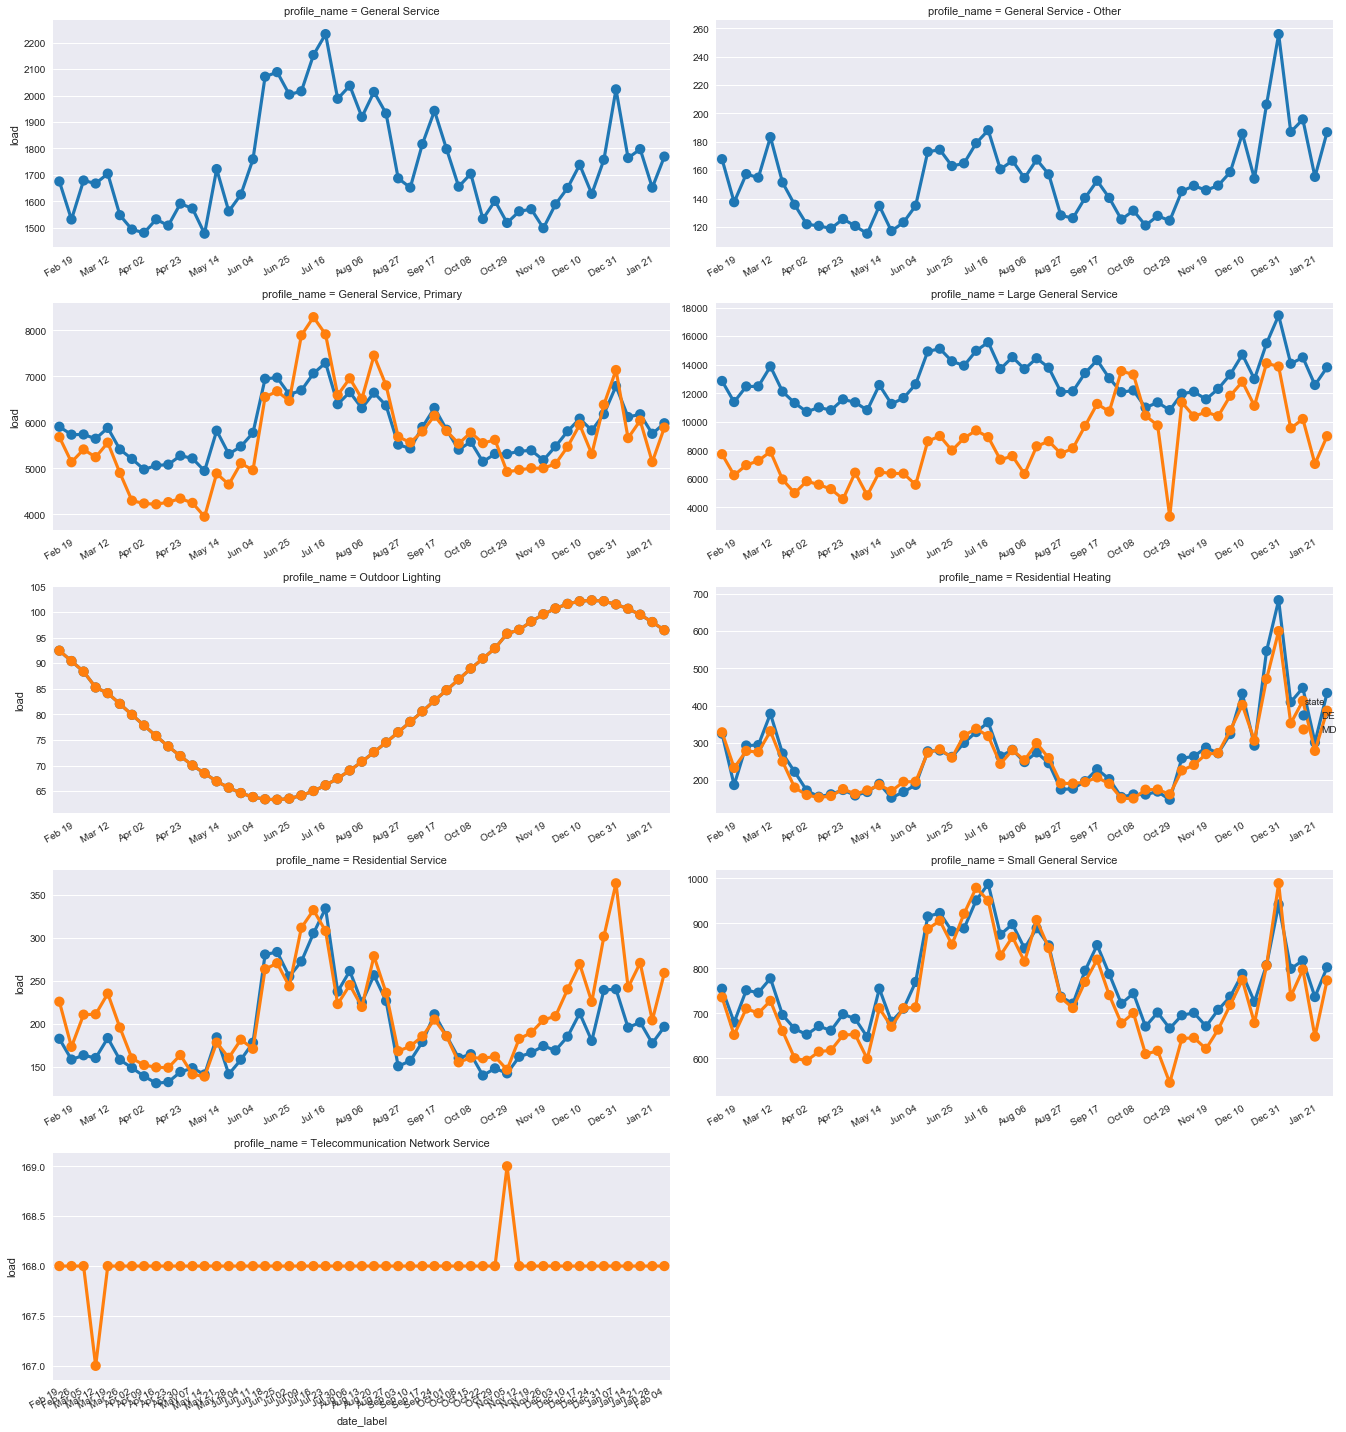

In [19]:
grouper = [pd.Grouper(freq='W'), 'state', 'profile_name']
data = lp_tidy.set_index('date').groupby(grouper)['load'].sum().sort_index()
core = [df.iloc[1:-1] for i, df in data.groupby(level=['state', 'profile_name'])]
data = (pd.concat(core)
        .reset_index()
        .assign(date_label=lambda df: df.date.dt.strftime('%b %d')))
g = sns.factorplot(x='date_label', y='load', hue='state', col='profile_name', col_wrap=2,
                   aspect=2.25, data=data, size=4, sharey=False, kind='point', 
                   palette='tab10')
g.fig.autofmt_xdate();
for ax in g.axes:
    plt.setp(ax.get_xticklabels()[::3], visible=True, rotation=30)
plt.tight_layout();

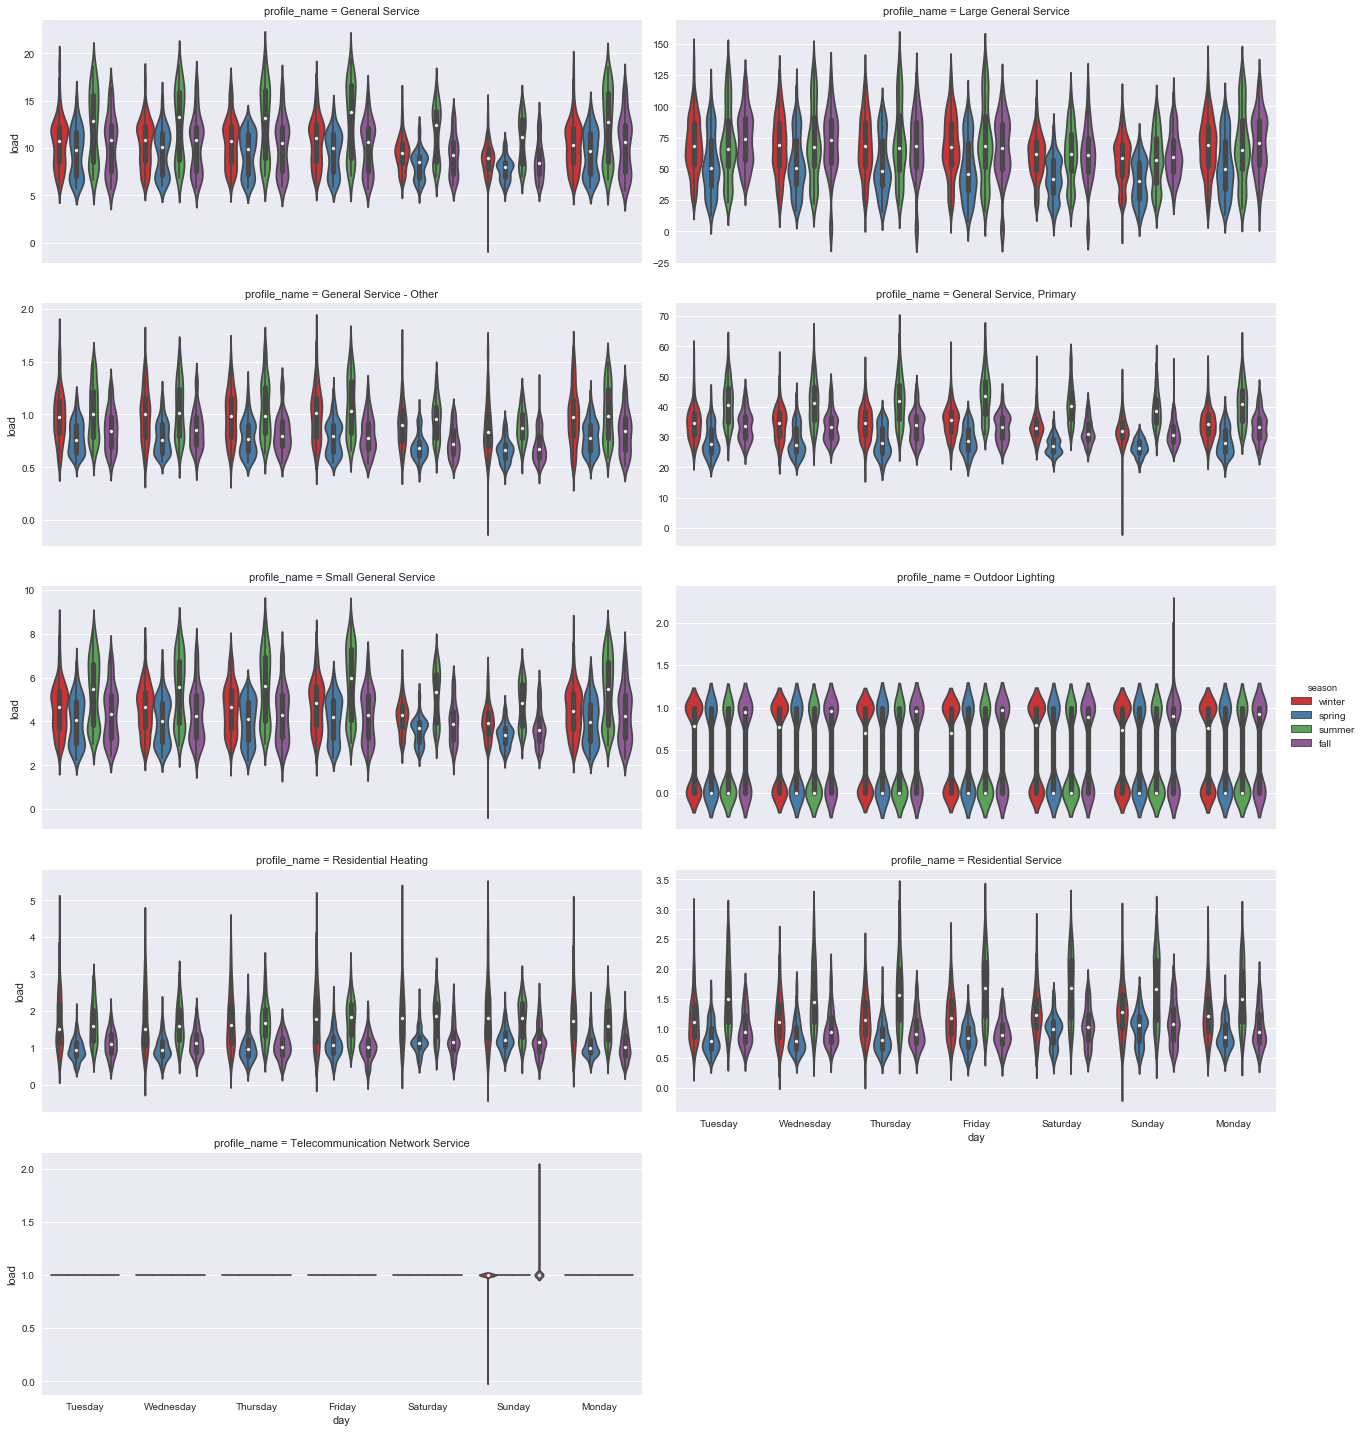

In [20]:
g = sns.factorplot(x='day', y='load', data=lp_tidy, hue='season',
                   col='profile_name', col_wrap=2,
                  aspect=2.25, sharey=False, kind='violin', palette='Set1')

## Residential Customers

In [21]:
residential = lp_tidy.query('customer_type == "Residential"').copy()
residential['day_type'] = np.where(residential.date.dt.dayofweek < 5, 'weekday', 'weekend')

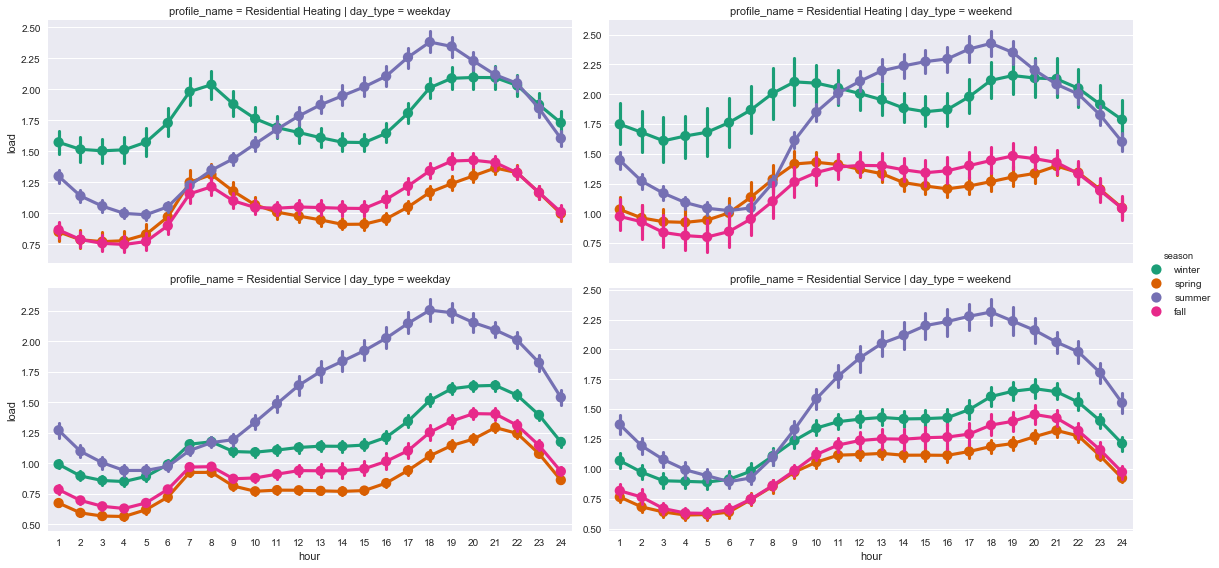

In [22]:
g = sns.factorplot(x='hour', y='load', data=residential, hue='season', 
                   row='profile_name', col='day_type',
                  palette='Dark2', kind='point', aspect=2, sharey=False)

As you can see, Residential Heating customers have higher usage during the winter than non-heating customers, which is to be expected.  The heating component refers to the fact that they use electricity to heat their homes rather than natural gas or another fuel source.